### Youtube API から情報取得

In [4]:
from googleapiclient.discovery import build
import json
import datetime
from dateutil.relativedelta import relativedelta

# チャンネルIDを別ファイルから取得
import src.channelId as cid
import src.videoId as vid

# 必要モジュールのインポート
import os
from dotenv import load_dotenv

# .envファイルの内容を読み込見込む
load_dotenv()

# API情報
API_KEY = os.environ['API_KEY']
API_NAME = 'youtube'
API_VERSION = 'v3'

video_id_list = [] # 動画IDをリストとして取得
video_info_list = [] # APIで取得した動画情報を格納する配列


##### API レスポンス

```py
{
 "kind": "youtube#videoListResponse",
 "etag": "\"UCBpFjp2h75_b92t44sqraUcyu0/sDAlsG9NGKfr6v5AlPZKSEZdtqA\"",
 "videos": [
  {
   "id": "7lCDEYXw3mM",
   "kind": "youtube#video",
   "etag": "\"UCBpFjp2h75_b92t44sqraUcyu0/iYynQR8AtacsFUwWmrVaw4Smb_Q\"",
   "snippet": {
    "publishedAt": "2012-06-20T22:45:24.000Z",
    "channelId": "UC_x5XG1OV2P6uZZ5FSM9Ttw",
    "title": "Google I/O 101: Q&A On Using Google APIs",
    "description": "Antonio Fuentes speaks to us and takes questions on working with Google APIs and OAuth 2.0.",
    "thumbnails": {
     "default": {
      "url": "https://i.ytimg.com/vi/7lCDEYXw3mM/default.jpg"
     },
     "medium": {
      "url": "https://i.ytimg.com/vi/7lCDEYXw3mM/mqdefault.jpg"
     },
     "high": {
      "url": "https://i.ytimg.com/vi/7lCDEYXw3mM/hqdefault.jpg"
     }
    },
    "categoryId": "28"
   },
   "contentDetails": {
    "duration": "PT15M51S",
    "aspectRatio": "RATIO_16_9"
   },
   "statistics": {
    "viewCount": "3057",
    "likeCount": "25",
    "dislikeCount": "0",
    "favoriteCount": "17",
    "commentCount": "12"
   },
   "status": {
    "uploadStatus": "STATUS_PROCESSED",
    "privacyStatus": "PRIVACY_PUBLIC"
   }
  }
 ]
}
```

In [30]:
def getVideoIdFromChannelId(page_token, start_date, end_date, channel_id=cid.CHANNEL_ID[0]):
    youtube = build(
        API_NAME,
        API_VERSION,
        developerKey = API_KEY
    )

    # 以下で指定した結果を格納する変数
    search_response = youtube.search().list(
        channelId = channel_id,
        part = 'snippet',
        # fields='items(id,snippet(title,description,publishedAt),contentDetails(duration),statistics(viewCount,likeCount,dislikeCount,commentCount))',
        type = 'video',
        maxResults = 50,                # search()1回で取得できる上限が50件（指定できるのは 0~50）
        publishedAfter = start_date,    # この日から
        publishedBefore = end_date,     # この日まで
        pageToken = page_token
    ).execute()


    # この回で取得できる総件数
    print(search_response["pageInfo"]["totalResults"])


    for search_result in search_response.get("items", []):

        # 取得した情報の分類が”動画”の場合（e.g. チャンネル："youtube#channel" / プレイリスト："youtube#playlist"）
        if search_result["id"]["kind"] == "youtube#video":

            # 選択したデータから辞書を作成する
            d = {'id': search_result["id"]["videoId"],}

            # 動画IDをリストに追加
            video_id_list.append(search_result["id"]["videoId"])


    # 動画IDを表示
    print(video_id_list)


    try:
        nextPage_token =  search_response["nextPage_Token"]
        # print(nextPage_token)
        getVideoIdFromChannelId(nextPage_token, start_date, end_date)
    except:
        return

In [33]:
def getVideoInfoFromVideoId(api_key, video_id):
    comments = []
    page_token = ''

    while page_token != None:
        resource = getVideoInfoFromVideoId(api_key, video_id, page_token)

        for comment_thread in resource['items']:
            # コメント取得
            comment = comment_thread['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

            if ('replies' in comment_thread) and ('comments' in comment_thread['replies']):
                for replies in comment_thread['replies']['comments']:
                    # コメント取得
                    reply_comment = replies['snippet']['textDisplay']
                    comments.append(reply_comment)

        if 'nextPageToken' in resource:
            page_token = resource['nextPageToken']
        else:
            page_token = None
    return comments

# print(get_video_comments(API_KEY, vid.VIDEO_ID[0]))

In [34]:
# 指定した日付から1ヶ月分のデータを取得
dt = datetime.datetime(2022, 1, 1, 0, 0)

# 指定した日時をisoフォーマットで表示
print(dt.isoformat())

# month=1の数字を変えると〜ヶ月分のデータ取得
# getVideoIdFromChannelId('', dt.isoformat()+'Z', (dt + relativedelta(months=1)).isoformat()+'Z')
getVideoInfoFromVideoId('', dt.isoformat()+'Z', (dt + relativedelta(months=1)).isoformat()+'Z')

2022-01-01T00:00:00


TypeError: Got an unexpected keyword argument publishedAfter

In [13]:
# 動画IDのリストを別ファイルに書き込む
with open("./src/videoId.py", mode="w") as f_videoId:
    f_videoId.write("VIDEO_ID = [\n")
    for video_id in video_id_list:
        f_videoId.write("\t\'" + video_id + "\',\n")
    f_videoId.write("]")

In [ ]:
# 選択した動画情報をjsonファイルに書き込む
with open("./result/result.json", mode="w", encoding="utf-8") as f_result:
    # 辞書をjsonファイルとして保存 json.dump(辞書, ファイルオブジェクト, ensure_ascii, インデント)
    json.dump(video_info_list, f_result, ensure_ascii=False, indent=2)

### ワードクラウド

##### 形態素解析

In [ ]:
# Mecab + NEologd で形態素解析
import MeCab

# .envファイルからNEologdがあるパスを取得
import os
from dotenv import load_dotenv
load_dotenv()
NEOLOGD_PATH = os.environ['NEOLOGD_PATH']

# -dで参照するディレクトリを指定
mct = MeCab.Tagger('-d' + NEOLOGD_PATH)

# 配列で用意したテキストファイルを読み込んで1つのテキストに変換
import src.lyric as lyrics
text = ""
for lyric in lyrics.LYRIC_LIST:
    text += lyric

# 形態素解析
node = mct.parse(text)

# 形態素解析結果を表示
# print(node)

##### 単語リスト（名詞）

In [ ]:
# 正規表現用
import re

# 単語ごとに格納するリストを用意
word_list = []

# 形態素解析結果を1行ずつ渡して名詞であればword_listに追加
for line in node.splitlines():
    word = line.split("\t")[0] # 分割結果の前半部分
    criteria = line.split("\t")[-1] # 分割結果の後半部分

    # 形態素解析結果で名詞が先頭にある場合word_listに追加
    if criteria.split(",")[0] in ["名詞"]:
        # あ〜んとa~zの1文字または2文字の単語のとき処理をpass
        if re.search(r'^[あ-ん]{1,2}|^[a-z]{1,2,3}$', word):
            pass
        else:
            word_list.append(word)

# 単語リストを表示
# print(word_list)


##### ストップワードリスト

In [ ]:
# slothlibを使ってstop_word_listを作成
import requests

SLOTHLIB_URL = os.environ['SLOTHLIB_URL']
url = SLOTHLIB_URL
r = requests.get(url)
tmp = r.text.split('\r\n')

stop_word_list = []

for i in range(len(tmp)):
    if len(tmp[i]) < 1:
        continue
    stop_word_list.append(tmp[i])

# stop_word_listを表示
# print(stop_word_list)

##### ワードクラウド

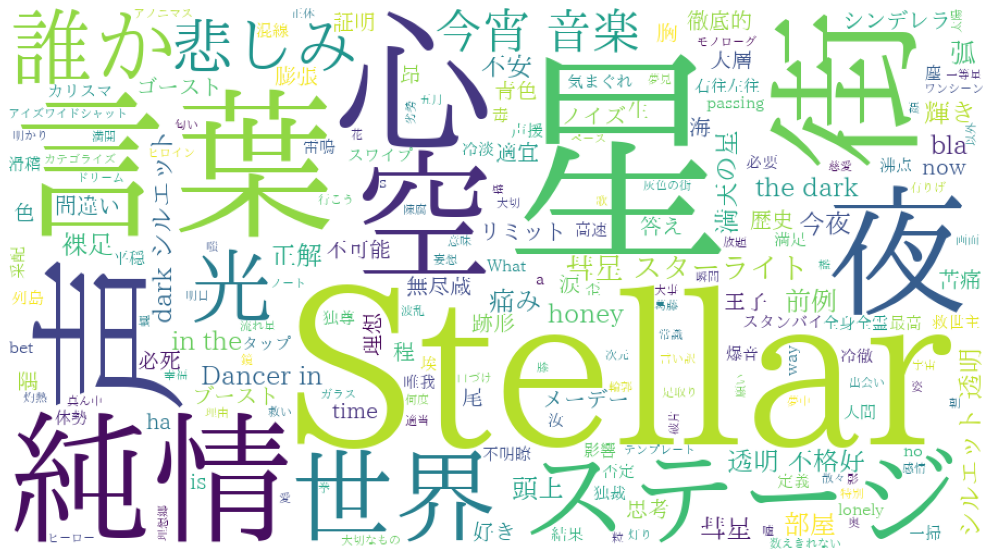

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# フォントを日本語用に変更する必要がある
# mpl.matplotlib_fname()で場所を調べられる
FONT_PATH = os.environ['FONT_PATH']
fpath = FONT_PATH

# 任意でstop_word_list二単語を追加
stop_word_list += ["僕", "君"]

wc = WordCloud(background_color="white",width=900, height=500, font_path=fpath, stopwords=stop_word_list).generate(' '.join(word_list))
plt.figure(figsize=(18,10))
plt.axis("off")
plt.imshow(wc)